## Colab Notebook created for ARAP module at UPC ETSETB.

Authors: Juan José Nieto, Margarita Cabrera-Bean, Josep Vidal

**Martí Farré, Adriana Díaz**

# WINDY GRID WORLD
[Open to access description of tasks](https://drive.google.com/file/d/1Pr0KKRO9-3JsEkcU6lAs8ZGopLs4lkKX/view?usp=sharing)

1. Complete the code for each algorithm (Sarsa, Q-Learning, Expected Sarsa and Double Q-Learning).
2. Add a stopping criterion consisting of stopping the training process when the return
$G(s_{ini})> G_{min} = -19$, measured using a window length $N_{av}= 5$ episodes, i.e. if after
measuring $G(s_{ini})$ in the last $N_{av}$ episodes, the average figure is > $G_{min}$
stop training.
3. Modify the environment creatively following the description of tasks document.


In [ ]:
import numpy as np
import seaborn as sns

from random import random, randint
import matplotlib.pyplot as plt
algs = ['SARSA', 'Q-LEARNING', 'EXPECTED SARSA', 'DOUBLE Q-LEARNING']

In [ ]:
class GridWorld():
    def __init__(self):
        self.N_ROWS = 10
        self.N_COLUMNS = 10
        self.N_STATES = self.N_ROWS * self.N_COLUMNS

        # Define parameters
        self.GAMMA = 1
        self.ALPHA = 0.5
        self.EPSILON = 0.1
        self.N_EPISODES = 2000

        # left/down/right/up action
        self.ACTIONS = [(0, -1), (1, 0), (0, 1), (-1, 0)]

        self.N_ACTIONS = len(self.ACTIONS)

        # Define inital and final state
        self.INI_STATE = 6
        self.FIN_STATE = 76

        # Define wind for each row and column
        self.WIND_V = [0, 0, 0, -1, -1, -1, -2, -2, -1, 0]
        self.WIND_H = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

        # Define action-value function
        self.Q_FUN = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define second action-value function for double q-learning
        self.Q_FUN2 = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define state-value function only for plotting purposes
        self.V_FUN = np.zeros(self.N_STATES)


    ''' Convert state s from scalar to coordinates x,y '''
    def get_XY(self, state):
        return (state % self.N_ROWS, int(state / self.N_ROWS))

    ''' Convert coordinates x,y to scalar state '''
    def get_state(self, state):
        return state[1]*self.N_COLUMNS + state[0]


    '''
    Computes next state and reward

    Params:
        - int: state in {0,..., N_STATES-1}
    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: reward
    '''
    def next_position(self, state, action):

        (x,y) = self.get_XY(state)
        # x is the row number and y is the column number
        (ax, ay) = self.ACTIONS[action]

        row = max(0, x + ax + self.WIND_V[y])
        row = min(self.N_ROWS-1, row)
        col = max(0, y + ay + self.WIND_H[x])
        col = min(self.N_COLUMNS-1, col)

        next_state = (row, col)

        next_state = self.get_state(next_state)

        if next_state == self.FIN_STATE:
            return next_state, 0
        return next_state, -1

    '''
    Performs greedy policy. With prob epsilon pick action
    belonging to maximum action-value. With prob 1-epsilon
    pick a random action.

    Params:
        - int: state in {0,..., N_STATES-1}
        - bool: double, indicates whether we are using double q-learning or not
    Returns:
        - int: action in {0,..., N_ACTIONS-1}
    '''
    def greedy_policy(self, state, double=False):

        action = np.argmax(self.Q_FUN[state])
        if double:
            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state])

        if random() < self.EPSILON:
            action = randint(0, self.N_ACTIONS - 1)

        return action

    '''
    Compute state-value function

    Returns:
        - list: V_FUN
    '''
    def compute_v_fun(self):
        for i, action_values in enumerate(self.Q_FUN):
            self.V_FUN[i] = np.max(self.Q_FUN[i] + self.Q_FUN2[i])  # QFUN2[i] will be != 0 only in Double Q-Learning
        return self.V_FUN

    '''
    Compute actions taken in each state.

    Params:
        - boolean: double, indicates whether we are using double q-learning or not
    Returns:
        - list: actions, one for each state
    '''
    def compute_actions(self, double=False):
        actions = []
        for s in range(self.N_STATES):
            if double:
                actions.append(np.argmax(self.Q_FUN[s] + self.Q_FUN2[s]))
            else:
                actions.append(np.argmax(self.Q_FUN[s]))

        return actions

    '''
    The following functions are the different algorithms we will try.
    Basically we do two things:
        1. Compute next_state and next_action
        2. Update action-values (Q_FUN)

    Params:
        - int: state in {0,..., N_STATES-1}
        - int: action in {0,..., N_ACTIONS-1}

    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: next_action in {0,..., N_ACTIONS-1}
    '''

    # WARNING: Note that some methods use the input variable: action and others do not
    def sarsa(self, state, action):

        # sarsa uses greedy policy for next action too

        next_state, reward = self.next_position(state, action)
        next_action = self.greedy_policy(next_state)

        # Update Q-value
        self.Q_FUN[state, action] += self.ALPHA * (reward + self.GAMMA * self.Q_FUN[next_state, next_action] - self.Q_FUN[state, action])

        return next_state, next_action

    def q_learning(self, state, action):
        action = self.greedy_policy(state)
        next_state, reward = self.next_position(state, action)

        # Q-Learning update rule
        self.Q_FUN[state, action] += self.ALPHA * (reward + self.GAMMA * np.max(self.Q_FUN[next_state]) - self.Q_FUN[state, action])
        next_action = action
        return next_state, next_action

    def expected_sarsa(self, state, action):
        next_state, reward = self.next_position(state, action)
        next_action = self.greedy_policy(next_state)

        # Compute the expected SARSA update using epsilon-greedy policy
        # expected sarsa is like q-learning but weighting with epsilon and also taking into account
        # the rest of action-values of that state
        expected_value = 0
        for a in range(self.N_ACTIONS):
          if a != next_action:
            prob = self.EPSILON / self.N_ACTIONS
          else:
            prob = (self.EPSILON / self.N_ACTIONS) + (1 - self.EPSILON)

          expected_value += prob * self.Q_FUN[next_state, a]

        # Expected SARSA update rule
        self.Q_FUN[state, action] += self.ALPHA * (reward + self.GAMMA * expected_value - self.Q_FUN[state, action])

        return next_state, next_action

    def double_q_learning(self, state, action):
        action = grid.greedy_policy(state, double=True)
        next_state, reward = self.next_position(state, action)

        # Choose whether to update Q_FUN or Q_FUN2
        update_Q1 = np.random.rand() < 0.5

        if update_Q1:
            self.Q_FUN[state, action] += self.ALPHA * (reward + self.GAMMA * (max(self.Q_FUN2[next_state, :]) - self.Q_FUN[state, action]))

        else:
            self.Q_FUN2[state, action] += self.ALPHA * (reward + self.GAMMA * (max(self.Q_FUN[next_state, :]) - self.Q_FUN2[state, action]))

        next_action = action

        return next_state, next_action

    def deterministic_policy(self):
        max_steps = 50
        state = self.INI_STATE
        trajectory = np.zeros((self.N_ROWS, self.N_COLUMNS))
        steps = 0
        while not state == self.FIN_STATE and steps < max_steps:
            s = self.get_XY(state)
            trajectory[s[0], s[1]] = 1

            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state]) # QFUN2[i] will be != 0 only in Double Q-Learning
            next_state, reward = self.next_position(state, action)
            state = next_state
            steps += 1

        if steps == max_steps:
            steps = 'inf'
        return trajectory, steps


### PLOT FUNCTIONS

In [ ]:
'''Insert title, and axis labels to plots'''
def insert_labels(labels, ax):
    if 'title' in labels:
        ax.set_title(labels['title'])
    if 'xlabel' in labels:
        ax.set_xlabel(labels['xlabel'])
    if 'ylabel' in labels:
	    ax.set_ylabel(labels['ylabel'])

def general_plot(vf_matrix, counts, first_policy, optimal_policy, determ_policy, steps, grid, world):
    fig, ax = plt.subplots(5, len(vf_matrix), figsize=(20, 20))
    fig.tight_layout(pad=2.5)

    X = np.arange(0, grid.N_ROWS, 1)
    Y = np.arange(0, grid.N_COLUMNS, 1)

    if world == "GridWorld":
      s = 0.05
    if world == "CliffWorld":
      s = 0.1

    actions = grid.ACTIONS

    r,t = grid.get_XY(grid.INI_STATE)
    w,e = grid.get_XY(grid.FIN_STATE)

    ini_pad_y = (grid.N_ROWS - r)*2-1
    g_pad_y = (grid.N_ROWS - w)*2-1

    ini_pad_x = t*2+1
    g_pad_x = e*2+1

    ini_pad_x = s*ini_pad_x-s/2
    ini_pad_y = s*ini_pad_y-s/2

    g_pad_x = s*g_pad_x-s/2
    g_pad_y = s*g_pad_y-s/2

    for i, data in enumerate([vf_matrix, counts, first_policy, optimal_policy, determ_policy]):
        for j, d in enumerate(data):
            if i==0:
                sns.heatmap(d, cmap='coolwarm', ax=ax[i, j])
                conf = {'title': '{} VALUE FUNCTION'.format(algs[j])}
                insert_labels(conf, ax[i, j])
            elif i==1:
                conf= {
                    'title': 'Number of steps in each episode',
                    'xlabel': 'Episode #',
                    'ylabel': 'number of steps'
                }
                ax[i,j].plot(d)
                insert_labels(conf, ax[i, j])
            elif i==2 or i==3:
                U = np.array([[actions[y][0] for y in x] for x in d])
                V = np.array([[actions[y][1] for y in x] for x in d])

                q = ax[i,j].quiver(X, Y, V, U*-1)
                ax[i,j].imshow(d, cmap=plt.cm.Pastel1)

                ax[i,j].axis('off')
                conf= {'title': '{} Policy'.format('First' if i==2 else 'Final')}
                insert_labels(conf, ax[i,j])

            elif i==4:
                U = np.array([[actions[y][0] if determ_policy[j][l,p]==1 else 0 for p,y in enumerate(x)] for l,x in enumerate(optimal_policy[j])])
                V = np.array([[actions[y][1] if determ_policy[j][l,p]==1 else 0 for p,y in enumerate(x)] for l,x in enumerate(optimal_policy[j])])

                q = ax[i,j].quiver(X, Y, V, U*-1, scale=5.3, scale_units='inches')

                ax[i,j].text(ini_pad_x, ini_pad_y, 'INI', fontsize=14, transform=ax[i,j].transAxes)
                ax[i,j].text(g_pad_x, g_pad_y, 'G', fontsize=14, transform=ax[i,j].transAxes)
                ax[i,j].imshow(d, cmap=plt.cm.Pastel1)

                ax[i,j].axis('off')
                conf= {'title': 'Deterministic Policy. # Steps: {}'.format(steps[j])}
                insert_labels(conf, ax[i,j])


# ALGORITHMS:
1 -> SARSA

2 -> Q-LEARNING

3 -> EXPECTED SARSA

4 -> DOUBLE Q-LEARNING

# STANDARD GRID WORLD

In [ ]:

total_counts = []
total_v_funs = []
total_first_p = []
total_final_p = []
total_determ_p = []
total_steps = []

# Define stopping criterion
G_min = -19
N_av = 5

# List that tracks returns for the last N_av episodes
latest_returns = []

for ALGORITHM in range(1,5):
    grid = GridWorld()
    counts = []

    for i in range(grid.N_EPISODES):
        state = grid.INI_STATE
        action = grid.greedy_policy(state)
        n_count = 0

        while not state == grid.FIN_STATE:

            if ALGORITHM == 1:
                next_state, next_action = grid.sarsa(state, action)
            elif ALGORITHM == 2:
                next_state, next_action = grid.q_learning(state, action)
            elif ALGORITHM == 3:
                next_state, next_action = grid.expected_sarsa(state, action)
            elif ALGORITHM == 4:
                next_state, next_action = grid.double_q_learning(state, action)

            action = next_action
            state = next_state

            n_count += 1

        if i==0:
            first_policy = grid.compute_actions()

        counts.append(n_count)

        # Check if the latest returns list has reached N_av episodes
        if len(latest_returns) == N_av:
          average_return = np.mean(latest_returns)

          if average_return > G_min:
              break  # stop training if  stopping criterion is met

        # Remove the oldest return from the recent returns list if it's full
        if len(latest_returns) > N_av:
            latest_returns.pop(0)


    v_fun = grid.compute_v_fun()
    vf_matrix = np.transpose(np.reshape(v_fun, (grid.N_ROWS, grid.N_COLUMNS)))
    first_action_arrows = np.transpose(np.array(first_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    final_policy = grid.compute_actions(double=True)
    final_action_arrows = np.transpose(np.array(final_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    determ_policy, steps = grid.deterministic_policy()

    total_v_funs.append(vf_matrix)
    total_counts.append(counts)
    total_first_p.append(first_action_arrows)
    total_final_p.append(final_action_arrows)
    total_determ_p.append(determ_policy)
    total_steps.append(steps)


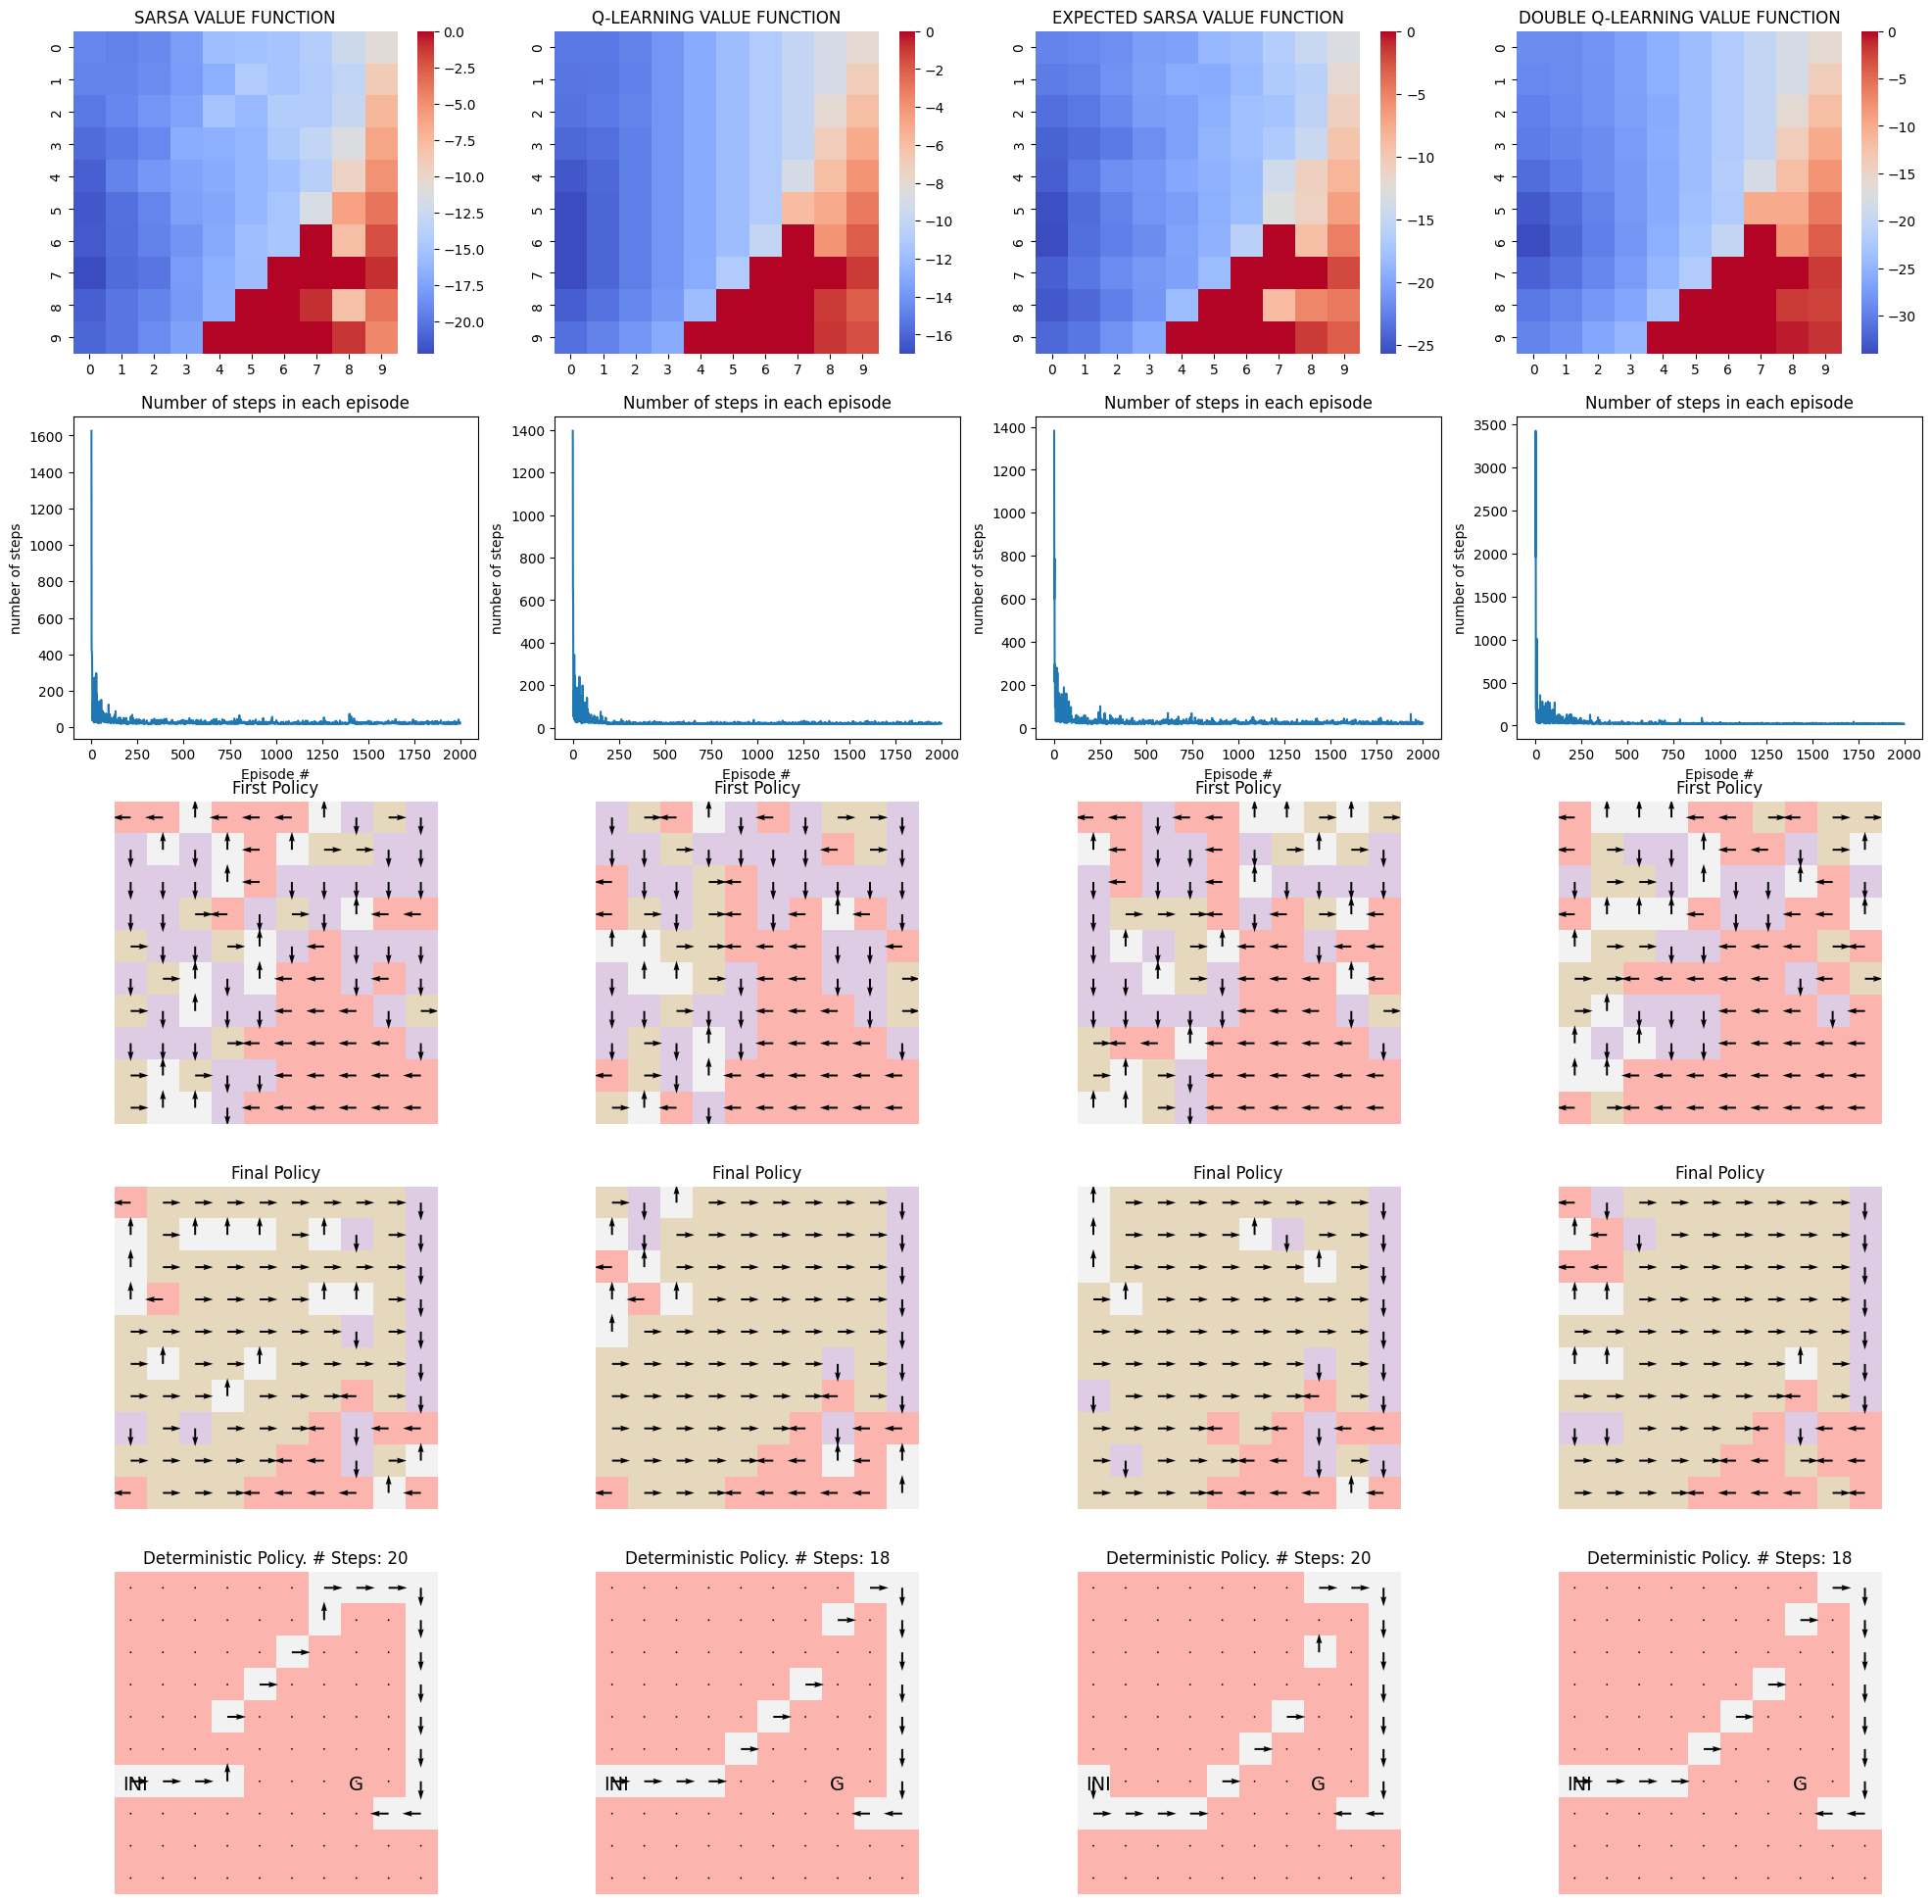

In [ ]:
general_plot(total_v_funs, total_counts, total_first_p, total_final_p, total_determ_p, total_steps, grid, "GridWorld")

# Cliff WORLD

In [ ]:
class CliffWorld():
    def __init__(self):
        self.N_ROWS = 5
        self.N_COLUMNS = 5
        self.N_STATES = self.N_ROWS * self.N_COLUMNS

        # Define parameters
        self.GAMMA = 1
        self.ALPHA = 0.5
        self.EPSILON = 0.1
        self.N_EPISODES = 2000

        # left/down/right/up action
        self.ACTIONS = [(0, -1), (1, 0), (0, 1), (-1, 0)]

        self.N_ACTIONS = len(self.ACTIONS)

        # Define inital and final state
        self.INI_STATE = 3  # [3,0] in the state encoding
        self.FIN_STATE = 22  # [2,4] in the state encoding


        # Define forbidden states
        self.FORBIDDEN_STATES = set([(1, i) for i in range(1, 4)])
        self.FORBIDDEN_STATES.update([(2, i) for i in range(1, 4)])

        # Define cliff states
        self.CLIFF_STATES = set([(4, i) for i in range(5)])


        # Define action-value function
        self.Q_FUN = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define second action-value function for double q-learning
        self.Q_FUN2 = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define state-value function only for plotting purposes
        self.V_FUN = np.zeros(self.N_STATES)

    ''' Convert state s from scalar to coordinates x,y '''
    def get_XY(self, state):
        return (state % self.N_ROWS, int(state / self.N_ROWS))

    ''' Convert coordinates x,y to scalar state '''
    def get_state(self, state):
        return state[1] * self.N_COLUMNS + state[0]

    '''
    Computes next state and reward

    Params:
        - int: state in {0,..., N_STATES-1}
    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: reward
    '''
    def next_position(self, state, action):

        (x, y) = self.get_XY(state)
        # x is the row number and y is the column number
        (ax, ay) = self.ACTIONS[action]

        # Check if the chosen action would lead to an invalid state
        new_row = max(0, x + ax)
        new_col = max(0, y + ay)

        if self.get_state((new_row, new_col)) == self.FIN_STATE:
            next_state = self.get_state((new_row, new_col))
            return next_state, 0

        if (new_row, new_col) in self.FORBIDDEN_STATES:
            # If the chosen action would lead to an invalid state, stay in the current state
            reward = -1
            next_state = state

        else:
            # If the chosen action is valid, move to the new state
            row = new_row
            row = min(self.N_ROWS - 1, row)
            col = new_col
            col = min(self.N_COLUMNS - 1, col)

            next_state = self.get_state((row, col))

            # Check if we landed on a cliff state
            if (row, col) in self.CLIFF_STATES:
                reward = -100
                next_state = self.INI_STATE  # Reset to initial state

            else:
                reward = -1

        return next_state, reward


    '''
    Performs greedy policy. With prob epsilon pick action
    belonging to maximum action-value. With prob 1-epsilon
    pick a random action.

    Params:
        - int: state in {0,..., N_STATES-1}
        - bool: double, indicates whether we are using double q-learning or not
    Returns:
        - int: action in {0,..., N_ACTIONS-1}
    '''
    def greedy_policy(self, state, double=False):

        action = np.argmax(self.Q_FUN[state])
        if double:
            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state])

        if random() < self.EPSILON:
            action = randint(0, self.N_ACTIONS - 1)

        return action

    '''
    Compute state-value function

    Returns:
        - list: V_FUN
    '''
    def compute_v_fun(self):
        for i, action_values in enumerate(self.Q_FUN):
            self.V_FUN[i] = np.max(self.Q_FUN[i] + self.Q_FUN2[i])  # QFUN2[i] will be != 0 only in Double Q-Learning
        return self.V_FUN

    '''
    Compute actions taken in each state.

    Params:
        - boolean: double, indicates whether we are using double q-learning or not
    Returns:
        - list: actions, one for each state
    '''
    def compute_actions(self, double=False):
        actions = []
        for s in range(self.N_STATES):
            if double:
                actions.append(np.argmax(self.Q_FUN[s] + self.Q_FUN2[s]))
            else:
                actions.append(np.argmax(self.Q_FUN[s]))

        return actions

    '''
    The following functions are the different algorithms we will try.
    Basically we do two things:
        1. Compute next_state and next_action
        2. Update action-values (Q_FUN)

    Params:
        - int: state in {0,..., N_STATES-1}
        - int: action in {0,..., N_ACTIONS-1}

    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: next_action in {0,..., N_ACTIONS-1}
    '''

    # WARNING: Note that some methods use the input variable: action and others do not
    def sarsa(self, state, action):

        # sarsa uses greedy policy for next action too

        next_state, reward = self.next_position(state, action)
        next_action = self.greedy_policy(next_state)

        # Update Q-value
        self.Q_FUN[state, action] += self.ALPHA * (reward + self.GAMMA * self.Q_FUN[next_state, next_action] - self.Q_FUN[state, action])

        return next_state, next_action

    def q_learning(self, state, action):
        action = self.greedy_policy(state)
        next_state, reward = self.next_position(state, action)

        # Q-Learning update rule
        self.Q_FUN[state, action] += self.ALPHA * (reward + self.GAMMA * np.max(self.Q_FUN[next_state]) - self.Q_FUN[state, action])
        next_action = action
        return next_state, next_action

    def expected_sarsa(self, state, action):
        next_state, reward = self.next_position(state, action)
        next_action = self.greedy_policy(next_state)

        # Compute the expected SARSA update using epsilon-greedy policy
        expected_value = 0
        for a in range(self.N_ACTIONS):
          if a != next_action:
            prob = self.EPSILON / self.N_ACTIONS
          else:
            prob = 1 - self.EPSILON + (self.EPSILON / self.N_ACTIONS)

          expected_value += prob * self.Q_FUN[next_state, a]

        # Expected SARSA update rule
        self.Q_FUN[state, action] += self.ALPHA * (reward + self.GAMMA * expected_value - self.Q_FUN[state, action])

        return next_state, next_action

    def double_q_learning(self, state, action):
        action = grid.greedy_policy(state, double=True)
        next_state, reward = self.next_position(state, action)

        # Choose whether to update Q_FUN or Q_FUN2
        update_Q1 = np.random.rand() < 0.5

        if update_Q1:
            self.Q_FUN[state, action] += self.ALPHA * (reward + self.GAMMA * (max(self.Q_FUN2[next_state, :]) - self.Q_FUN[state, action]))

        else:
            self.Q_FUN2[state, action] += self.ALPHA * (reward + self.GAMMA * (max(self.Q_FUN[next_state, :]) - self.Q_FUN2[state, action]))


        next_action = action

        return next_state, next_action

    def deterministic_policy(self):
        max_steps = 50
        state = self.INI_STATE
        trajectory = np.zeros((self.N_ROWS, self.N_COLUMNS))
        steps = 0
        while not state == self.FIN_STATE and steps < max_steps:
            s = self.get_XY(state)
            trajectory[s[0], s[1]] = 1

            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state]) # QFUN2[i] will be != 0 only in Double Q-Learning
            next_state, reward = self.next_position(state, action)
            state = next_state
            steps += 1

        if steps == max_steps:
            steps = 'inf'
        return trajectory, steps


In [ ]:
total_counts = []
total_v_funs = []
total_first_p = []
total_final_p = []
total_determ_p = []
total_steps = []

# Define stopping criterion
G_min = -19
N_av = 5

# List that tracks returns for the last N_av episodes
latest_returns = []

for ALGORITHM in range(1,5):
    grid = CliffWorld()
    counts = []
    for i in range(grid.N_EPISODES):
        state = grid.INI_STATE
        action = grid.greedy_policy(state)
        n_count = 0

        while not state == grid.FIN_STATE:

            if ALGORITHM == 1:
                next_state, next_action = grid.sarsa(state, action)
            elif ALGORITHM == 2:
                next_state, next_action = grid.q_learning(state, action)
            elif ALGORITHM == 3:
                next_state, next_action = grid.expected_sarsa(state, action)
            elif ALGORITHM == 4:
                next_state, next_action = grid.double_q_learning(state, action)

            action = next_action
            state = next_state

            n_count += 1

        if i==0:
            first_policy = grid.compute_actions()

        counts.append(n_count)

        # Check if the latest returns list has reached N_av episodes
        if len(latest_returns) == N_av:
          average_return = np.mean(latest_returns)

          if average_return > G_min:
              break  # stop training if  stopping criterion is met

        # Remove the oldest return from the recent returns list if it's full
        if len(latest_returns) > N_av:
            latest_returns.pop(0)

    v_fun = grid.compute_v_fun()
    vf_matrix = np.transpose(np.reshape(v_fun, (grid.N_ROWS, grid.N_COLUMNS)))
    first_action_arrows = np.transpose(np.array(first_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    final_policy = grid.compute_actions(double=True)
    final_action_arrows = np.transpose(np.array(final_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    determ_policy, steps = grid.deterministic_policy()

    total_v_funs.append(vf_matrix)
    total_counts.append(counts)
    total_first_p.append(first_action_arrows)
    total_final_p.append(final_action_arrows)
    total_determ_p.append(determ_policy)
    total_steps.append(steps)


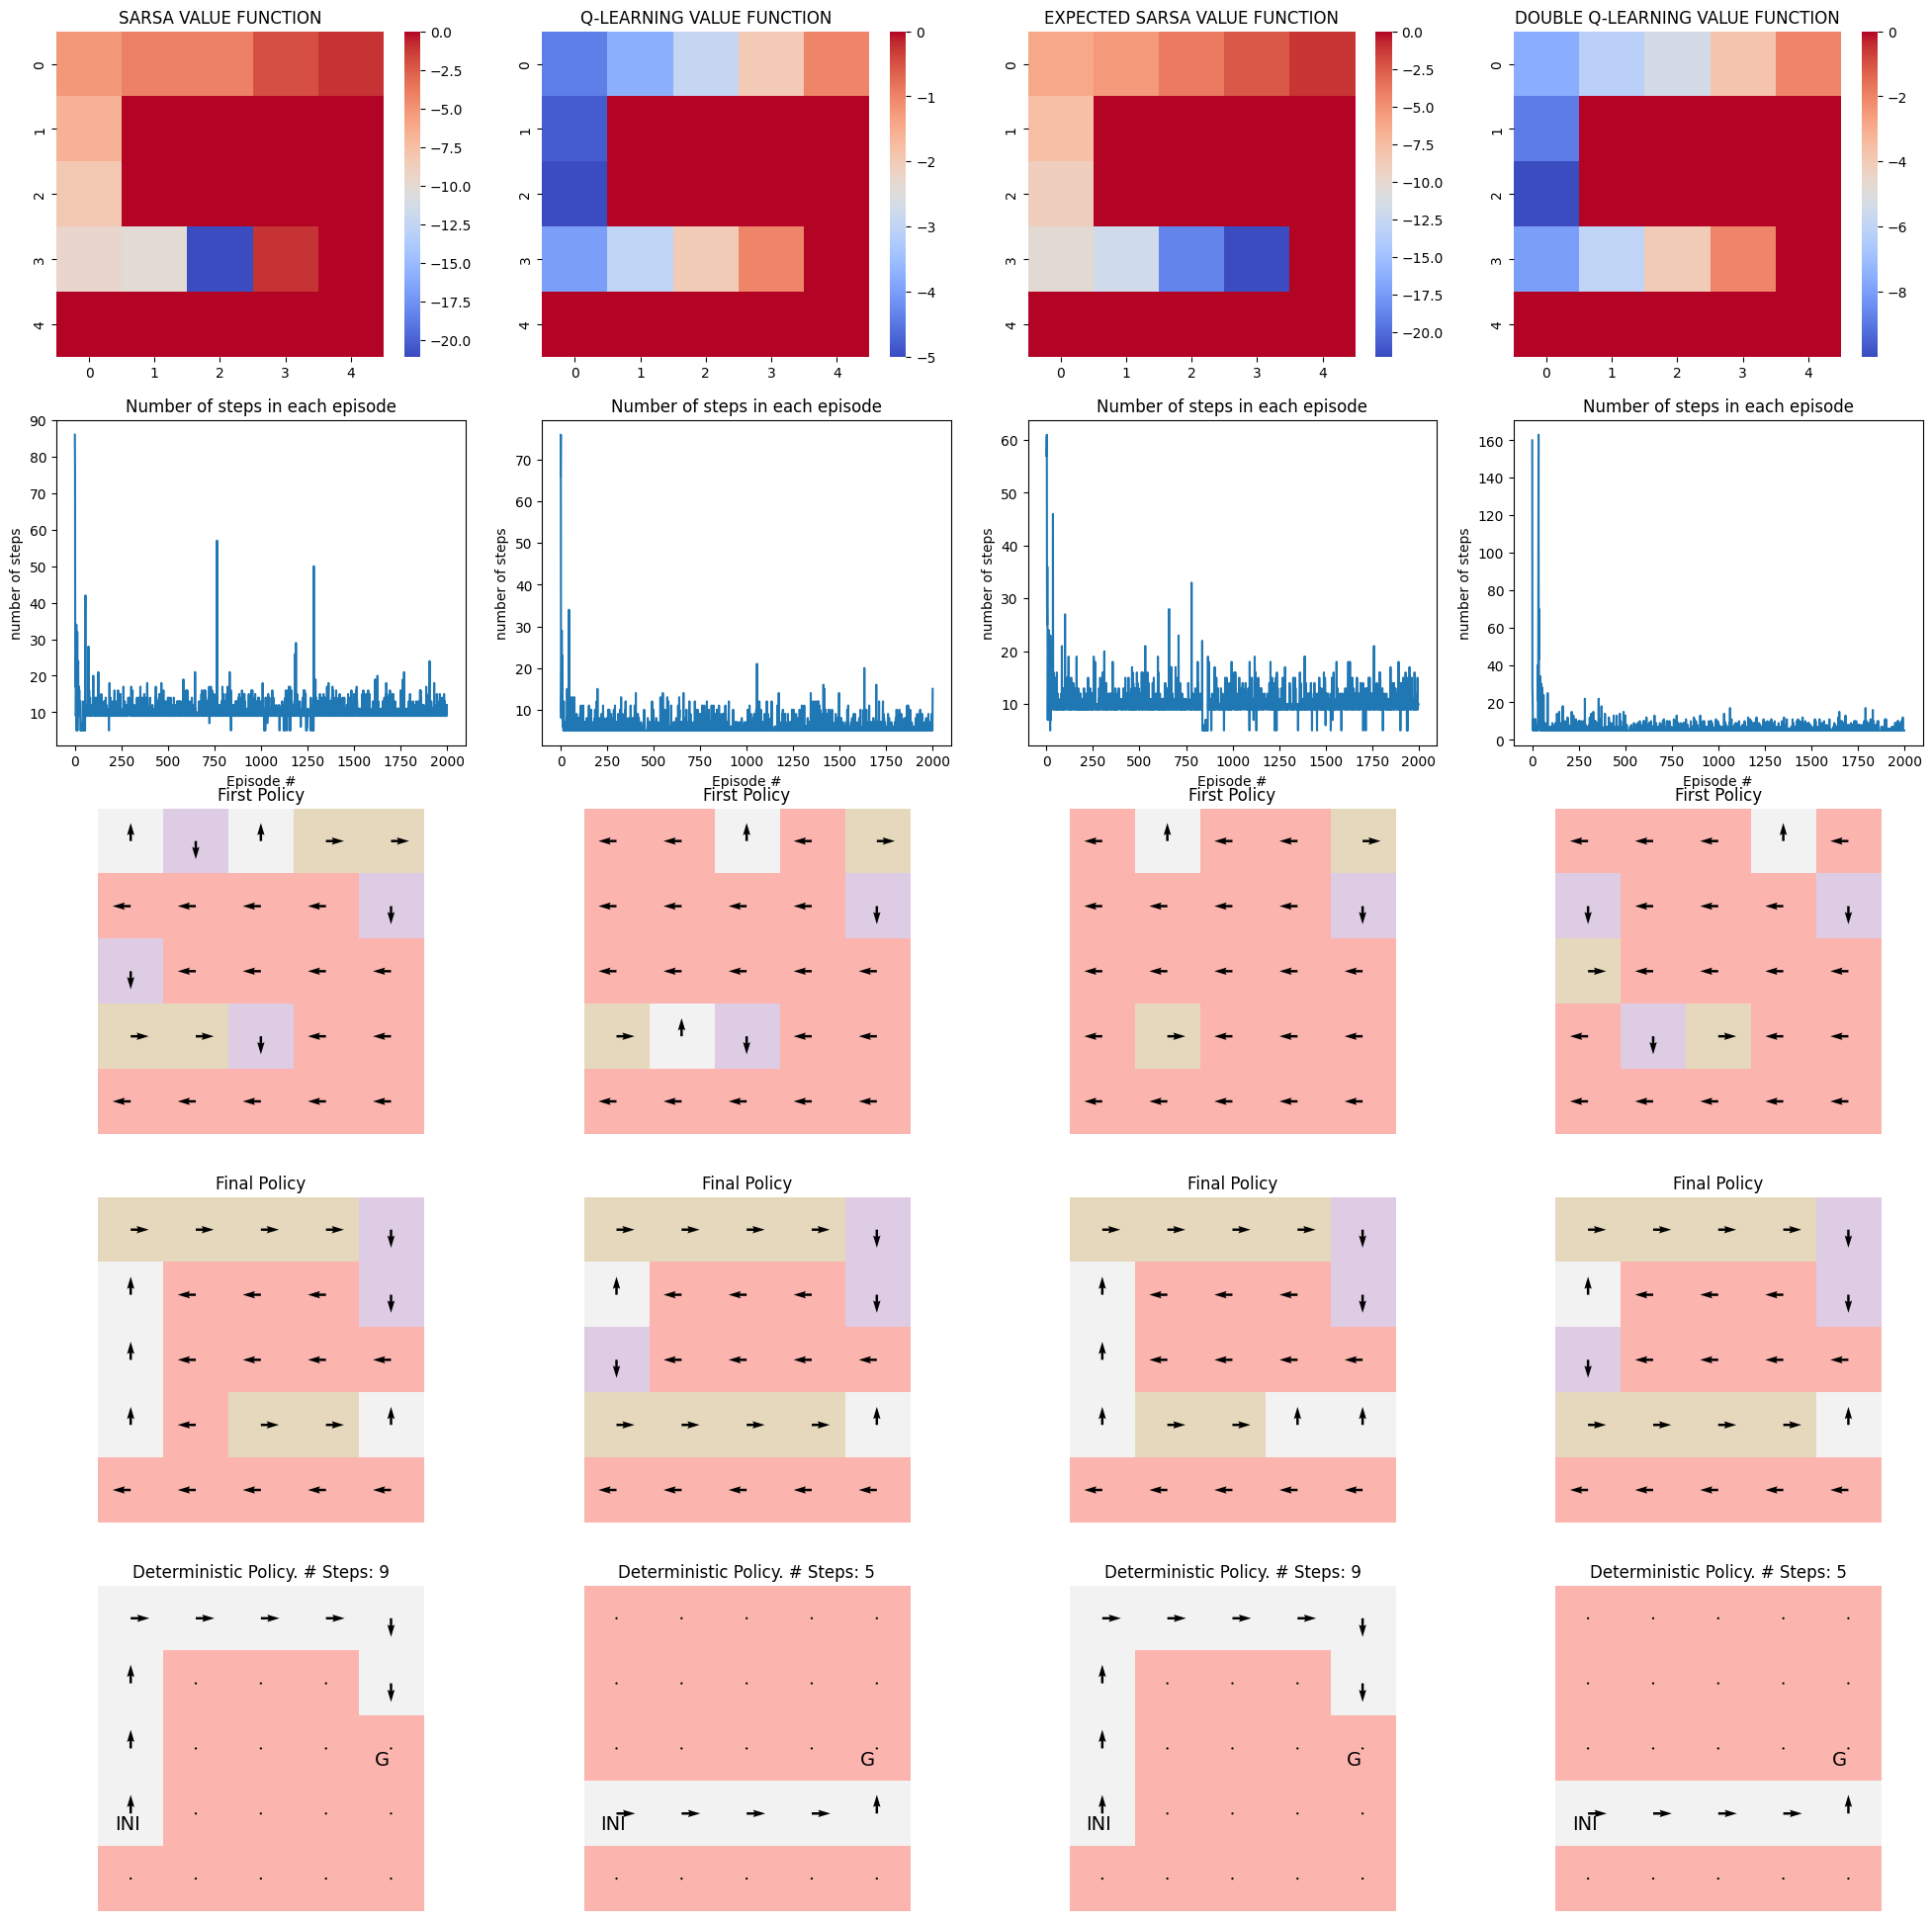

In [ ]:
general_plot(total_v_funs, total_counts, total_first_p, total_final_p, total_determ_p, total_steps, grid, "CliffWorld")

--------------------------

# Report

## Question 1
**Complete the functions to implement SARSA, Expected-SARSA, Q-learning and Double Q-Learning. Note that in the TD functions, you must program only one step of the episode. The main algorithm invokes the training process in a loop where updates the state and action at the end of each step and stops episode when final stated has been reached.**

In order to complete the implementations of the different algorithms, we needed to compute the updates of Q, which are the following:

- for SARSA: $Q(S,A) ← Q(S,A) + \alpha [R + \gamma Q(S',A') - Q(S,A)]$

- for Q-learning: $Q(S,A) ← Q(S,A) + \alpha [R + \gamma max_a Q(S',a) - Q(S,A)]$

- for Expected SARSA: $Q(S,A) ← Q(S,A) + \alpha [R + \gamma E_{\pi} [Q(S',A')|S'] - Q(S,A)]$

  $Q(S,A) ← Q(S,A) + \alpha [R + \gamma \sum_{a} \pi(a|S') Q(S',a) - Q(S,A)]$

- for Double Q-learning: $Q_1(S,A) ← Q_1(S,A) + \alpha [R + \gamma Q_2(S', argmax_a Q_1(S',a) - Q_1(S,A)]$

  $Q_2(S,A) ← Q_2(S,A) + \alpha [R + \gamma Q_1(S', argmax_a Q_2(S',a) - Q_2(S,A)]$

All the functions (SARSA,  Expected-SARSA, Q-learning and Double Q-Learning) can be found implemented in the definition of the class GridWorld.

As seen in class, SARSA and Expected-SARSA have as input the tuple *(state, action)*, and in every update we calculate *(S', A', R)* and return the tuple *(S', A')*, but the other two methods don't. Their input is just *state* and when we update the function we calculate *(A, S', R)* and we only return *(S')*. In the code we also return a ficticious *(A')* so the code generalizes correctly.

It should be noted that, in Expected SARSA, the $\pi(a|S')$ (called *prob* in the code) that multiplies Q to compute the Expectation is defined weighting with epsilon as follows:

- if the action in question is the same as the next action: $\pi(a|S') = (\epsilon / N) + (1 - \epsilon)$
- otherwise: $\pi(a|S') = \epsilon / N$

being N the number of possible actions. It was done this way since it is a usual way to implement them.

## Question 2
**Add a stopping criterion consisting of stopping the training process when the return  $G(S_{ini}) > G_{min} = −19$ , measured using a window length  $N_{av} = 5$  episodes, i.e. if after measuring  $G(S_{ini})$  in the last  $N_{av}$  episodes, the average figure is $> G_{min}$  stop training.**

To add the specified stopping criterion in the training process, after the next state is computed (and the action and state are updated) we check if, in the latest $N_{av}$ runs the average is higher than $G_{min}$. To do so, we use a list *latest_returns* that keeps track of the returns for the last $N_{av}$ episodes.

On one hand, if the list is full (has length of $N_{av}$), we compute the average of the returns and check if this is higher than $G_{min}$. If so, we stop the training (break). On the other hand, if the length is higher than $N_{av}$, we remove the first element of the *latest_returns* to keep tracking the $N_{av}$ most recent ones only.

The implementation is as follows:


      # Check if the latest returns list has reached N_av episodes
      if len(latest_returns) == N_av:
        average_return = np.mean(latest_returns)
        if average_return > G_min:
            break  # stop training if  stopping criterion is met

      # Remove the oldest return from the recent returns list if it's full
      if len(latest_returns) > N_av:
          latest_returns.pop(0)


## Question 3
**Analyze the average number of episodes necessary to get convergence and the average number of steps of the optimal strategy obtained.**


After training all 4 algorithms, we obtain the following:

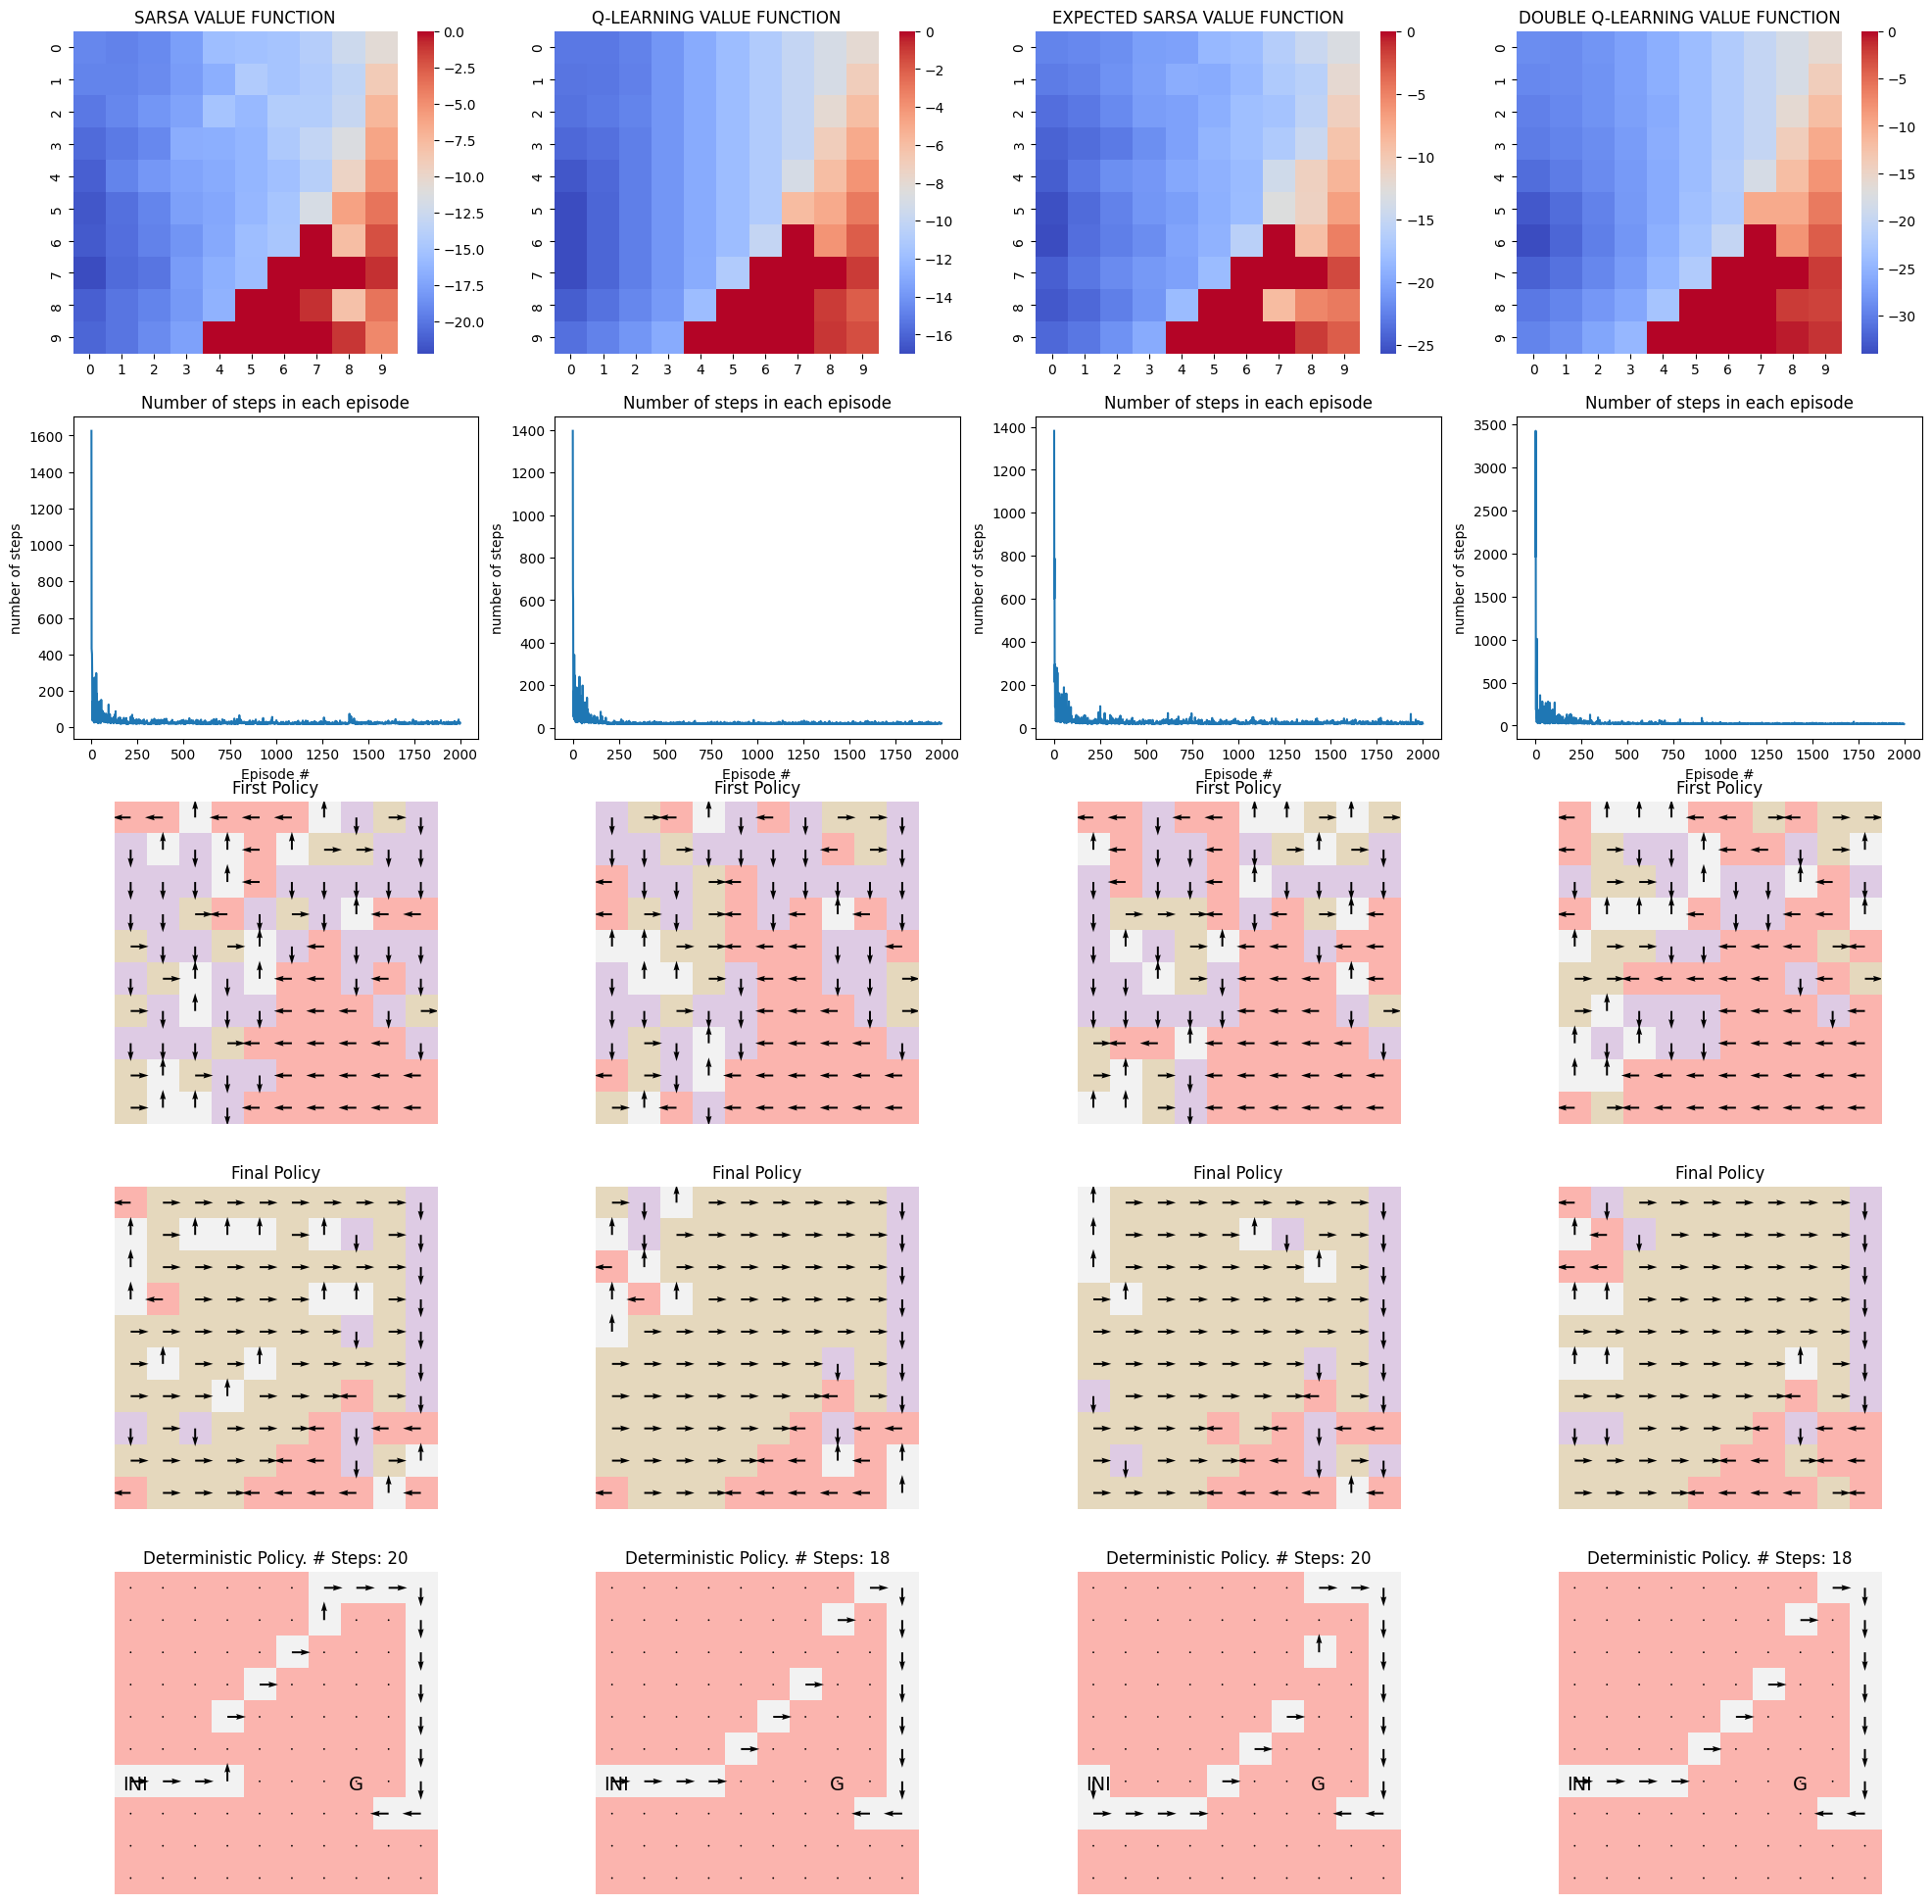

Regarding the number of episodes necessary to obtain converge, we can observe that both Q-learning and Double Q-learning converge faster than the other two algorithms, with the number of steps for the last episodes practically 0. Furthermore, as expected, Double Q-learning converges even faster than Q-learning due to its more accurate value estimations. However, it should be noted that Double Q-learning has a significantly higher number of steps in the first episode compared to the rest of the algorithms, which can be attributed to the initial exploration and variance in its dual value estimates.

Additionally, when comparing SARSA and Expected-SARSA, we can observe that they both take some time to converge. This behavior is due to the fact that these are on-policy methods, which focus on estimating the action-value function while following a policy derived from it. On the contrary, Q-learning and Double Q-learning are off-policy methods, which usually lead to faster convergence as they are less influenced by the exploration policy.

We will now proceed to analyze the average number of steps of the optimal strategy obtained for the different algorithms. For the SARSA and Expected-SARSA algorithm, the average number of states is 20. On the other hand, for Q-Learning and Double Q-learning, this value is 18. Once again, this behaviour is due to the exploration-exploitation strategies used in these algorithms.

On one hand, since SARSA and Expected-SARSA are on-policy alforithms, their policies tend to be more conservative (they prefer longer paths that are safer). Consecuently, it usually takes more steps to reach the optimal solutions. In contrast, Q-Learning and Double Q-learning are off-policy algorithms. This time, the number of states is lower because the exploration policy is more aggresive and leads to shorter paths.

## Question 4
**Modify the environment to emulate the Cliff grid world problem. This implies among other things to change GridWorld class and function next_position.**

For the cliff grid world problem we will have the following problem definition: reward is -1 on all transitions except those into the region marked “The Cliff.” Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start. Furthermore, there are some forbidden states.

To implement it, we used the same idea as for the GridWorld class, but performed some modifications. First, we needed to change the number of rows and columns and the initial and final states. Then, we define the forbidden states and the cliff states following the statement image.

After that, we needed to modify the next_position function of the class. This time, we check if the chosen action would lead to an invalid statet. If this chosen action leads to a forbidden state, the agent stays in the current state (next_state = state) and the reward is -1. Otherwise, if the chosen action is valid, we move to the new state. Nevertheless, we need to check whereas the agent has fallen into a cliff state. If this is the case, the reward is -100 and the agent returns to the initial state. If the agent does not land in the cliff, the reward is -1.

## Question 5
**Test how the algorithms SARSA, Expected-SARSA, Q-learning and Double Q-Learning work on the Cliff problem.**

After training all 4 algorithms for the Cliff problem, we obtain the following:

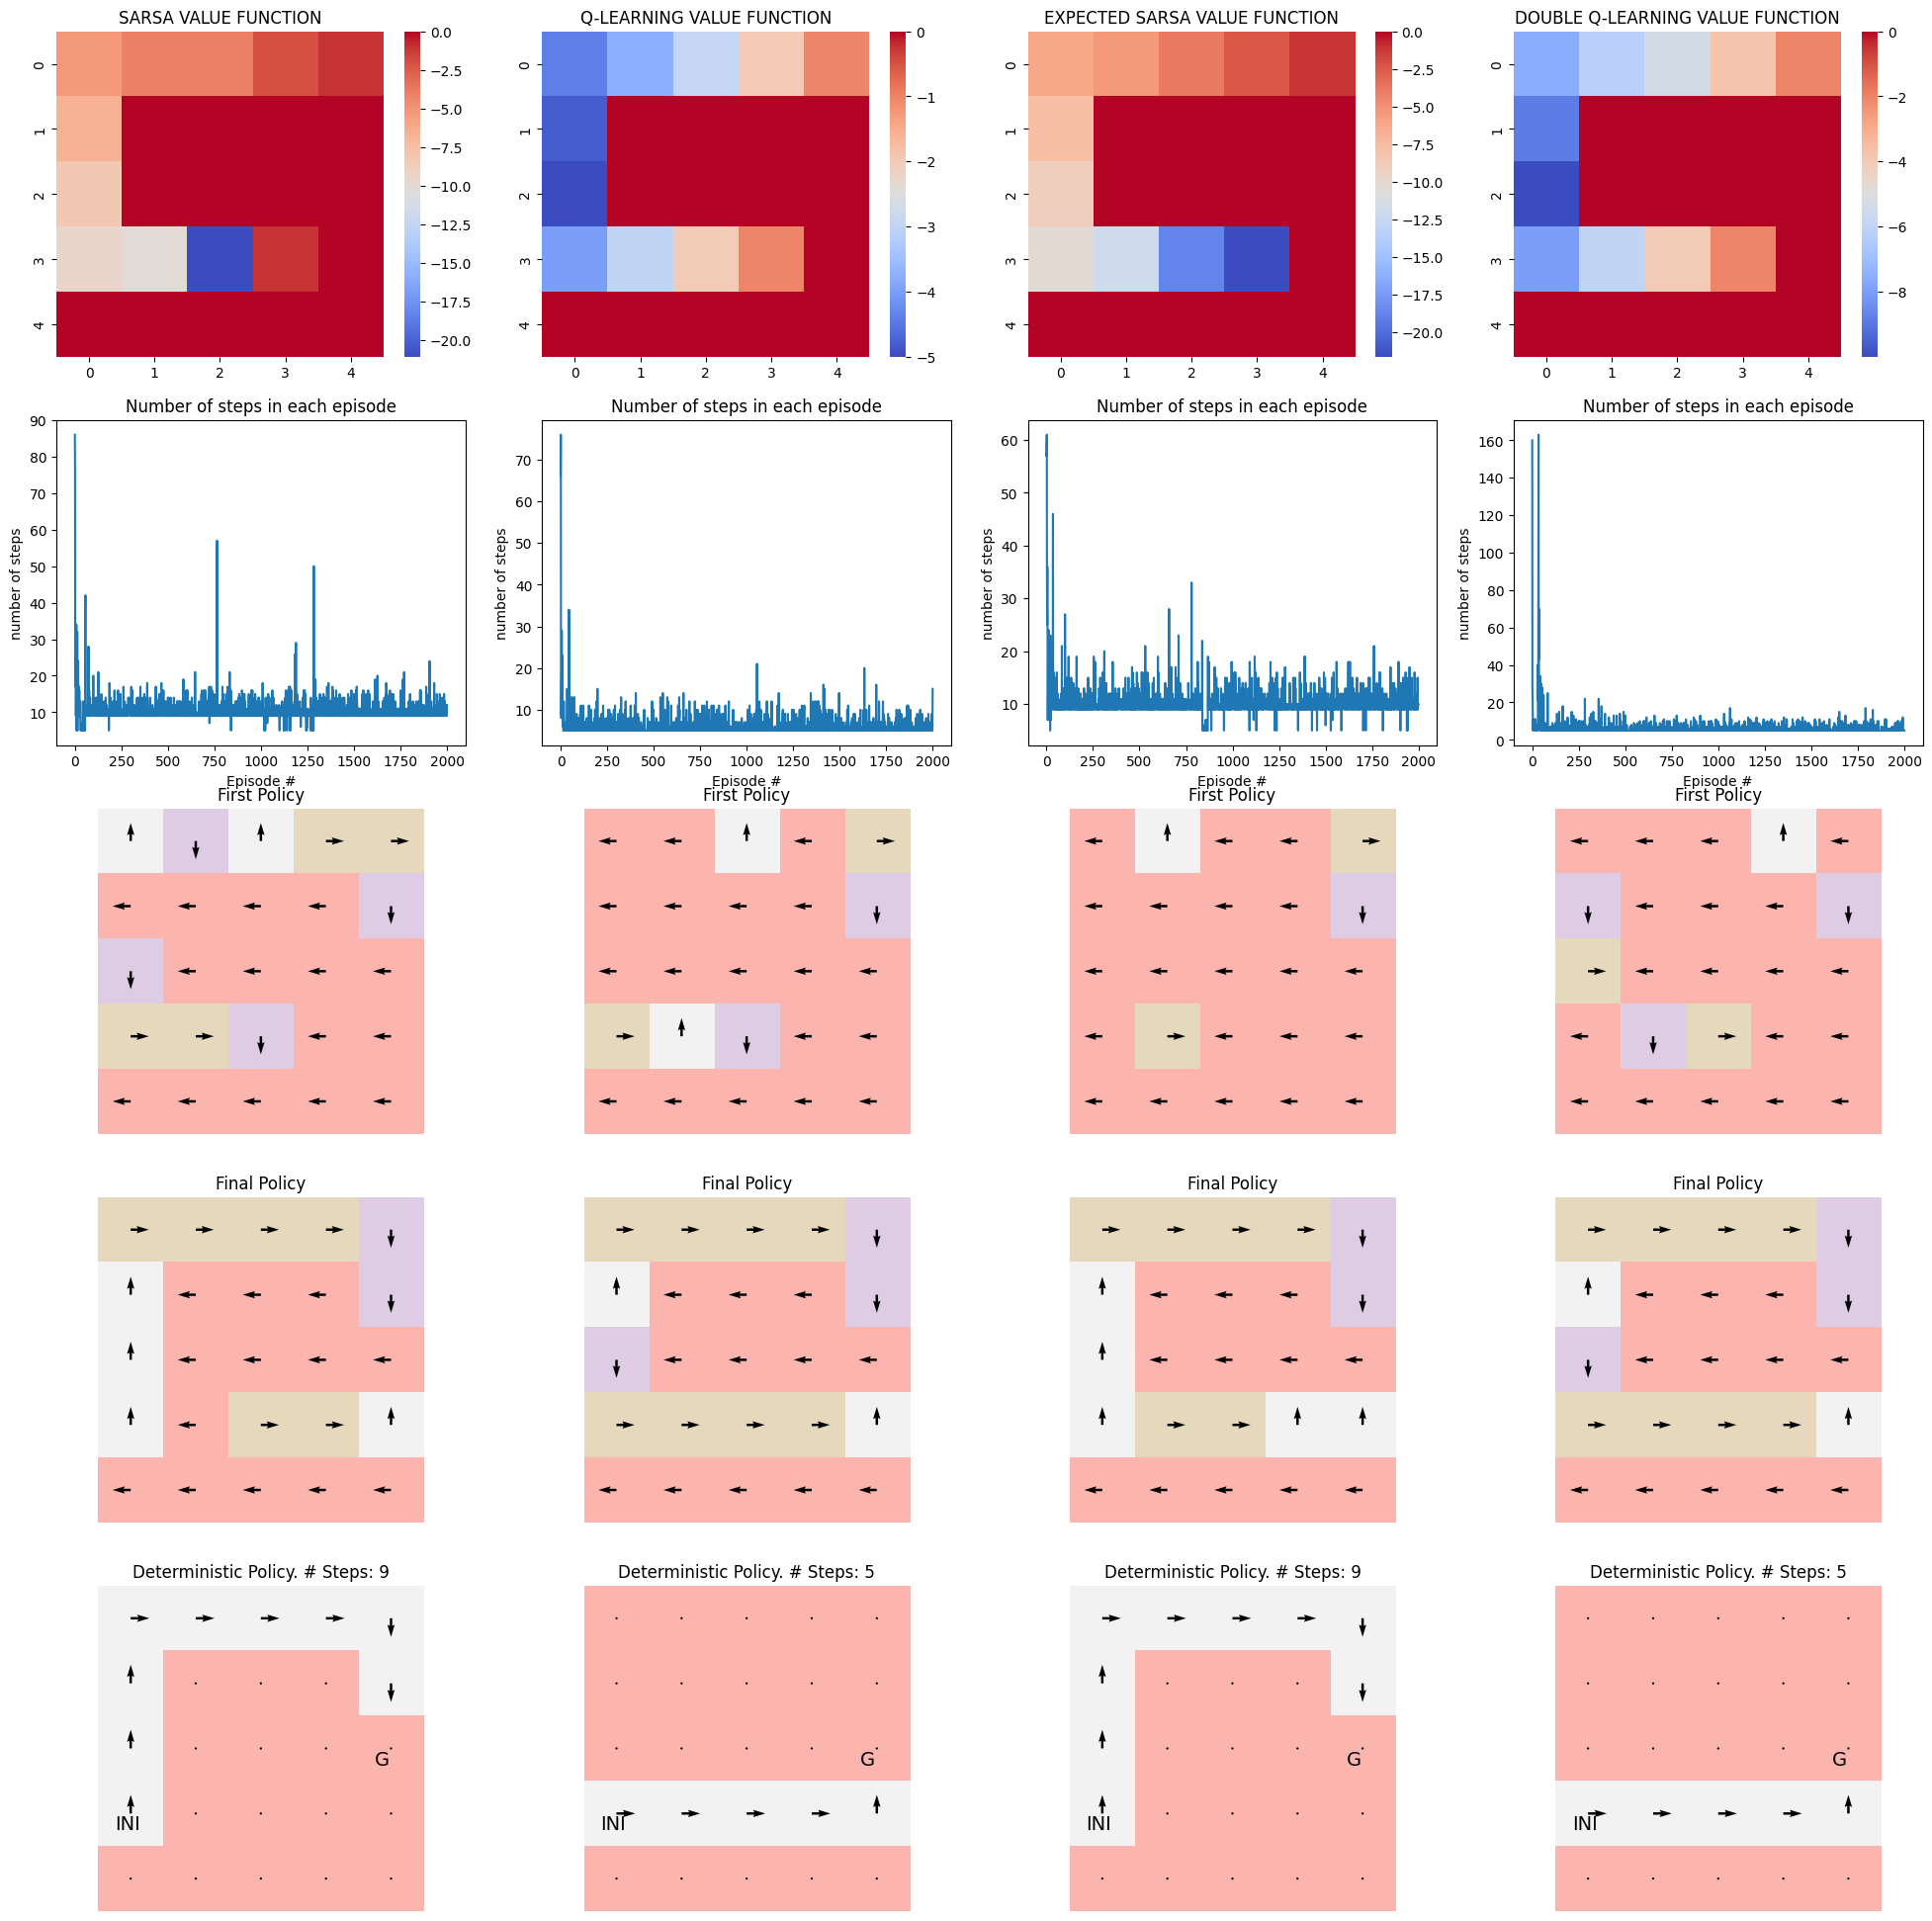

We can observe that the behaviour follows the same idea as before. First, Double Q-learning has a much higher number of states for the first episode due to the initial exploration and variance in its dual value estimates. Additionally, SARSA and Expected-SARSA are very similar in terms of number of episodes necessary to get convergence. Furthermore, Q-learning and Double Q-learning need a little bit less steps toe get to convergence. It should be noted that it is difficult to compare the plots between them due to the fact that they have different axis.

Once again,the optimal strategies obtained follow the same idea and justification as before. On one hand, SARSA and Expected-SARSA will follow a policy that is more conservative and avoids been near the cliff. For this reason, it prefers the longer but safer path. On the other hand, Q-learning and Double Q-learning have a more aggresive exploration, which leads to shorter paths to the optimal solution.
